# Técnica da camada equivalente aplicada ao processamento e inversão de dados magnéticos

Este código utiliza a biblioteca de modelagem e inversão de dados geofísicos denominada [Fatiando a Terra](http://www.fatiando.org/index.html) para exemplificar a aplicação da técnica da camada equivalente (Dampney, 1969; Emilia, 1973; Silva, 1986; Leão e Silva, 1989; Li e Oldenburg, 2010; Barnes e Lumley, 2011; Oliveira Jr. et al., 2013; Li et al., 2014) ao processamento e interpretação de dados magnéticos.

* Dampney, C. N. G., 1969, The equivalent source technique: GEOPHYSICS, 34, 39-53. doi: [10.1190/1.1439996](http://dx.doi.org/10.1190/1.1439996)

* Emilia, D. A., 1973, Equivalent sources used as an analytic base for processing total magnetic field profiles: GEOPHYSICS, 38, 339-348. doi: [10.1190/1.1440344](http://dx.doi.org/10.1190/1.1440344)

* Silva, J. B. C., 1986, Reduction to the pole as an inverse problem and its application to low-latitude anomalies: GEOPHYSICS, 51, 369-382. doi: [10.1190/1.1442096](http://dx.doi.org/10.1190/1.1442096)

* Leão, J. W. D., e J. B. C. Silva, 1989, Discrete linear transformations of potential field data: GEOPHYSICS, 54, 497-507. doi: [10.1190/1.1442676](http://dx.doi.org/10.1190/1.1442676)

* Li, Y., e D. W. Oldenburg, 2010, Rapid construction of equivalent sources using wavelets: GEOPHYSICS, 75, L51-L59. doi: [10.1190/1.3378764](http://dx.doi.org/10.1190/1.3378764)

* Barnes, G., e J. Lumley, 2011, Processing gravity gradient data: GEOPHYSICS, 76, I33-I47. doi: [10.1190/1.3548548](http://dx.doi.org/10.1190/1.3548548)

* Oliveira Jr., V. C., V. C. F. Barbosa, e L. Uieda, 2013, Polynomial equivalent layer: GEOPHYSICS, 78, G1-G13. doi: [10.1190/geo2012-0196.1](http://dx.doi.org/10.1190/geo2012-0196.1)

* Li, Y., M. Nabighian, e D. W. Oldenburg, 2014, Using an equivalent source with positivity for low-latitude reduction to the pole without striation: GEOPHYSICS, 79, J81-J90. doi: [10.1190/geo2014-0134.1](http://dx.doi.org/10.1190/geo2014-0134.1)

In [1]:
%matplotlib inline
import numpy as np
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere, prism
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion.regularization import Damping, Smoothness2D, LCurve
from fatiando.vis import mpl

### Pontos onde são calculados os dados

In [2]:
shape = (60, 60) # número de dados ao longo de x e y
N = shape[0]*shape[1] # número de dados
area = [-3000, 3000, -3000, 3000] # x mínimo, x máximo, y mínimo e y máximo da área
xp, yp, zp = gridder.regular(area, shape, z=-100) # grade regular localizada em z = -100 m

xc = 0.5*(area[1] + area[0])
yc = 0.5*(area[3] + area[2])

dx, dy = gridder.spacing(area, shape)

In [3]:
print dx
print dy

101.694915254
101.694915254


### Campo geomagnético local

In [4]:
inc = -30. # graus
dec = 40. # graus

### Corpos sintéticos

In [5]:
incs = inc
decs = dec
amps = 3.
rhos = 2000.

model = [mesher.Prism(-500., 500., -500., 500., 10., 1010., \
                      {'magnetization': utils.ang2vec(amps, incs, decs),
                       'density': rhos})]

In [6]:
# Projeção horizontal dos corpos
projecao = []
for i, p in enumerate(model):
    projecao.append(p.get_bounds()[:4])

### Anomalia de campo total (em nT)

In [7]:
act_aprox = prism.tf(xp, yp, zp, model, inc, dec)

### Componente vertical da atração gravitacional (em mGal)

In [8]:
gz = prism.gz(xp, yp, zp, model)

### Compentes do tensor gradiente da gravidade (em Eötvös)

In [9]:
gxx = prism.gxx(xp, yp, zp, model)
gxy = prism.gxy(xp, yp, zp, model)
gxz = prism.gxz(xp, yp, zp, model)
gyy = prism.gyy(xp, yp, zp, model)
gyz = prism.gyz(xp, yp, zp, model)
gzz = prism.gzz(xp, yp, zp, model)

### Plot dos dados

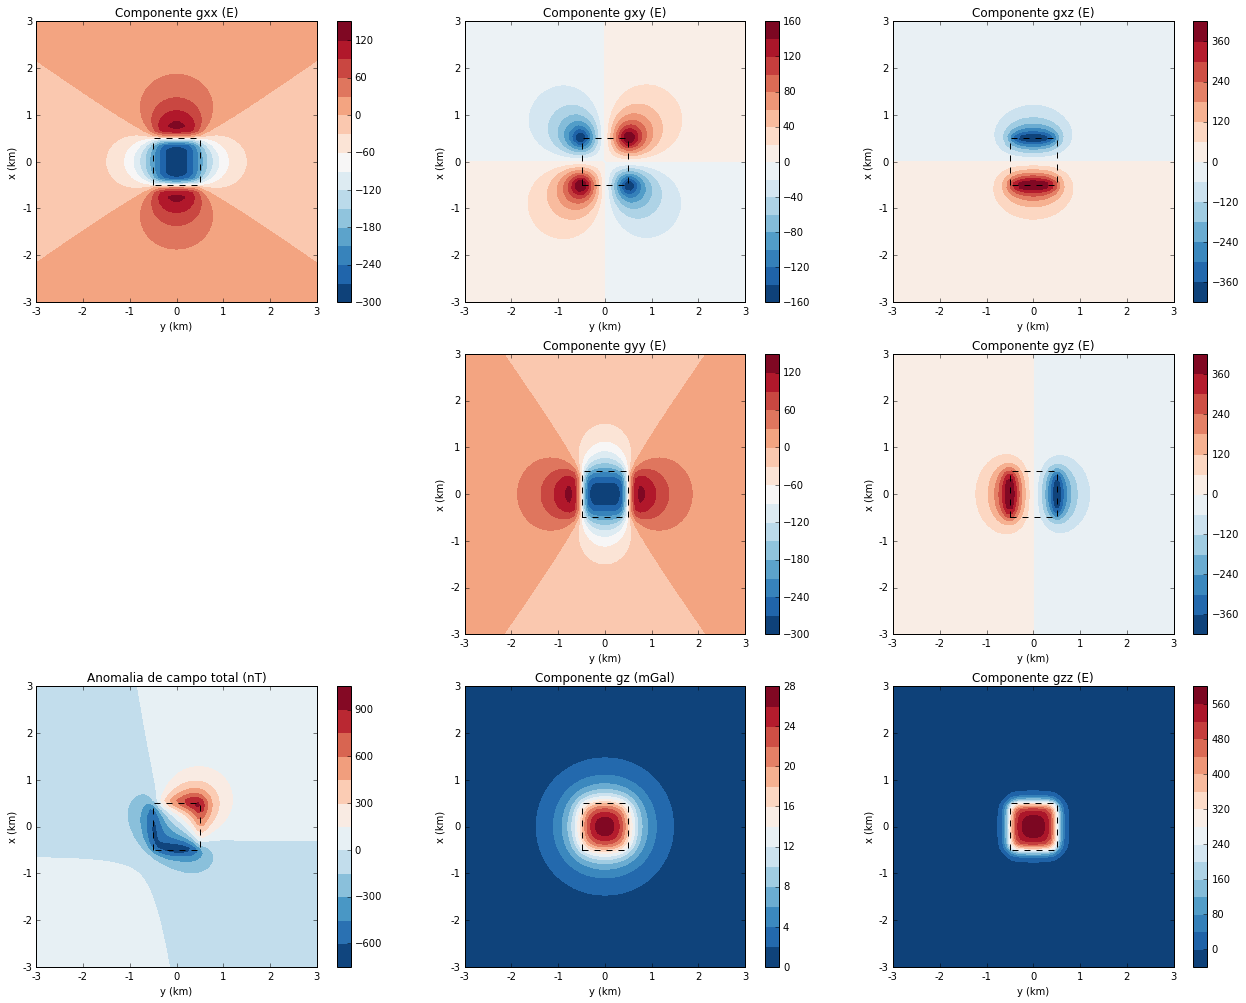

In [10]:
mpl.close('all')
mpl.figure(figsize=(18,14))

mpl.subplot(3,3,1)
mpl.title("Componente gxx (E)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gxx, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,2)
mpl.title("Componente gxy (E)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gxy, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,3)
mpl.title("Componente gxz (E)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gxz, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,5)
mpl.title("Componente gyy (E)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gyy, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,6)
mpl.title("Componente gyz (E)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gyz, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,9)
mpl.title("Componente gzz (E)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gzz, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,7)
mpl.title("Anomalia de campo total (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,8)
mpl.title("Componente gz (mGal)")
mpl.axis('scaled')
mpl.contourf(yp, xp, gz, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Construção de uma camada equivalente

In [11]:
#h = 3.*0.5*(dx+dy)
h = np.max(zp) + 200.
camada = mesher.PointGrid(area, h, shape)

In [12]:
ajuste = EQLTotalField(xp, yp, zp, act_aprox, inc, dec, camada, incs, decs)

In [13]:
f0 = np.trace(ajuste.hessian(None))/ajuste.nparams

In [14]:
regularizacao = Damping(camada.size)
#regularizacao = Smoothness2D(shape)

In [15]:
#u0 = 1.e-1*f0

In [16]:
#inversao = (ajuste + u0*regularizacao).fit()
inversao = LCurve(ajuste, regularizacao, [f0*(10.**i) for i in range(-15, -1)]).fit()

C:\Users\Vanderlei\Documents\fatiando\fatiando\inversion\base.py:800: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if p == 'null':


In [17]:
camada.addprop('magnetization', utils.ang2vec(inversao.estimate_, incs, decs))

In [18]:
act_pre = inversao.predicted()

In [19]:
#intensidade = np.sqrt(camada.props['magnetization'][:,0]**2. + \
#                      camada.props['magnetization'][:,1]**2. + \
#                      camada.props['magnetization'][:,2]**2.)

In [20]:
#declinacao = np.rad2deg(np.arctan2(camada.props['magnetization'][:,1], 
#                                   camada.props['magnetization'][:,0]))

In [21]:
#inclinacao = np.rad2deg(np.arcsin(camada.props['magnetization'][:,2]/intensidade))

mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Propriedade fisica estimada")
mpl.axis('scaled')
mpl.pcolor(camada.y, camada.x, intensidade, shape, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Ajuste

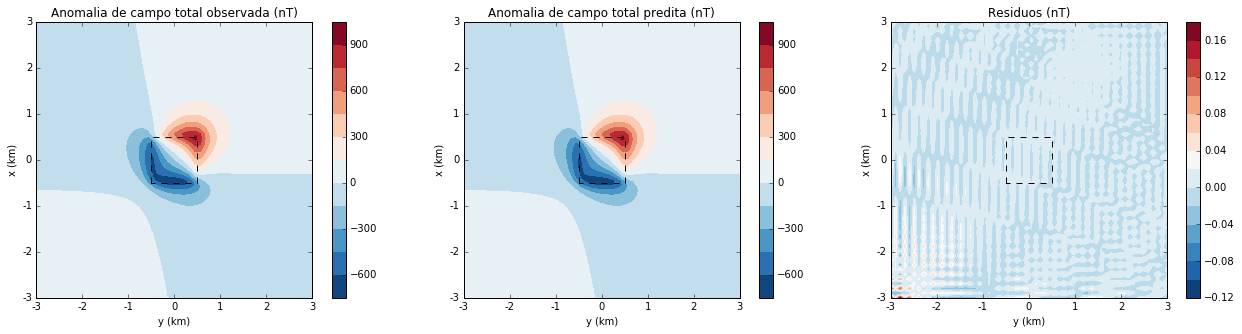

In [22]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total observada (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total predita (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_pre, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_pre - act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Continuação para cima

In [23]:
dado_verdadeiro = prism.tf(xp, yp, zp - 300., model, inc, dec)

In [24]:
dado_continuado = sphere.tf(xp, yp, zp - 300., camada, inc, dec)

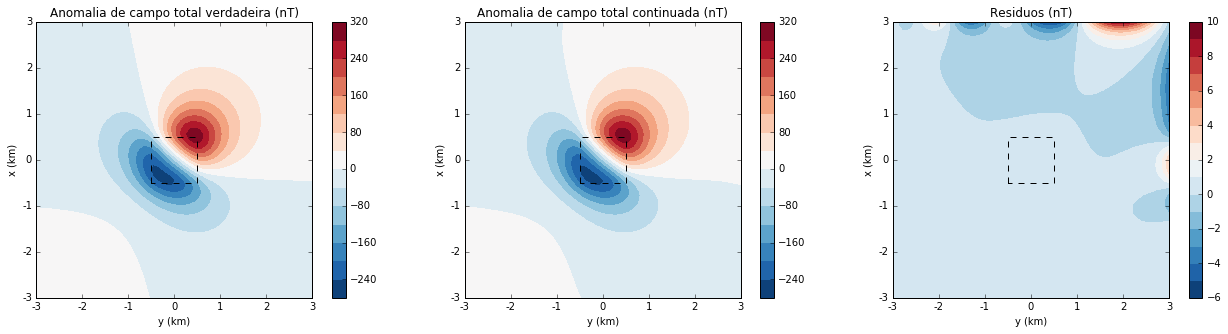

In [25]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total verdadeira (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total continuada (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_continuado, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_continuado - dado_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Cálculo de derivadas

In [26]:
delta = 10.

In [27]:
dx_verdadeira = (prism.tf(xp + delta, yp, zp, model, inc, dec) - \
                 prism.tf(xp - delta, yp, zp, model, inc, dec))/ \
                 (2.*delta)
dy_verdadeira = (prism.tf(xp, yp + delta, zp, model, inc, dec) - \
                 prism.tf(xp, yp - delta, zp, model, inc, dec))/ \
                 (2.*delta)
dz_verdadeira = (prism.tf(xp, yp, zp + delta, model, inc, dec) - \
                 prism.tf(xp, yp, zp - delta, model, inc, dec))/ \
                 (2.*delta)

In [28]:
dx_calculada = (sphere.tf(xp + delta, yp, zp, camada, inc, dec) - \
                sphere.tf(xp - delta, yp, zp, camada, inc, dec))/ \
               (2.*delta)
dy_calculada = (sphere.tf(xp, yp + delta, zp, camada, inc, dec) - \
                sphere.tf(xp, yp - delta, zp, camada, inc, dec))/ \
               (2.*delta)
dz_calculada = (sphere.tf(xp, yp, zp + delta, camada, inc, dec) - \
                sphere.tf(xp, yp, zp - delta, camada, inc, dec))/ \
               (2.*delta)

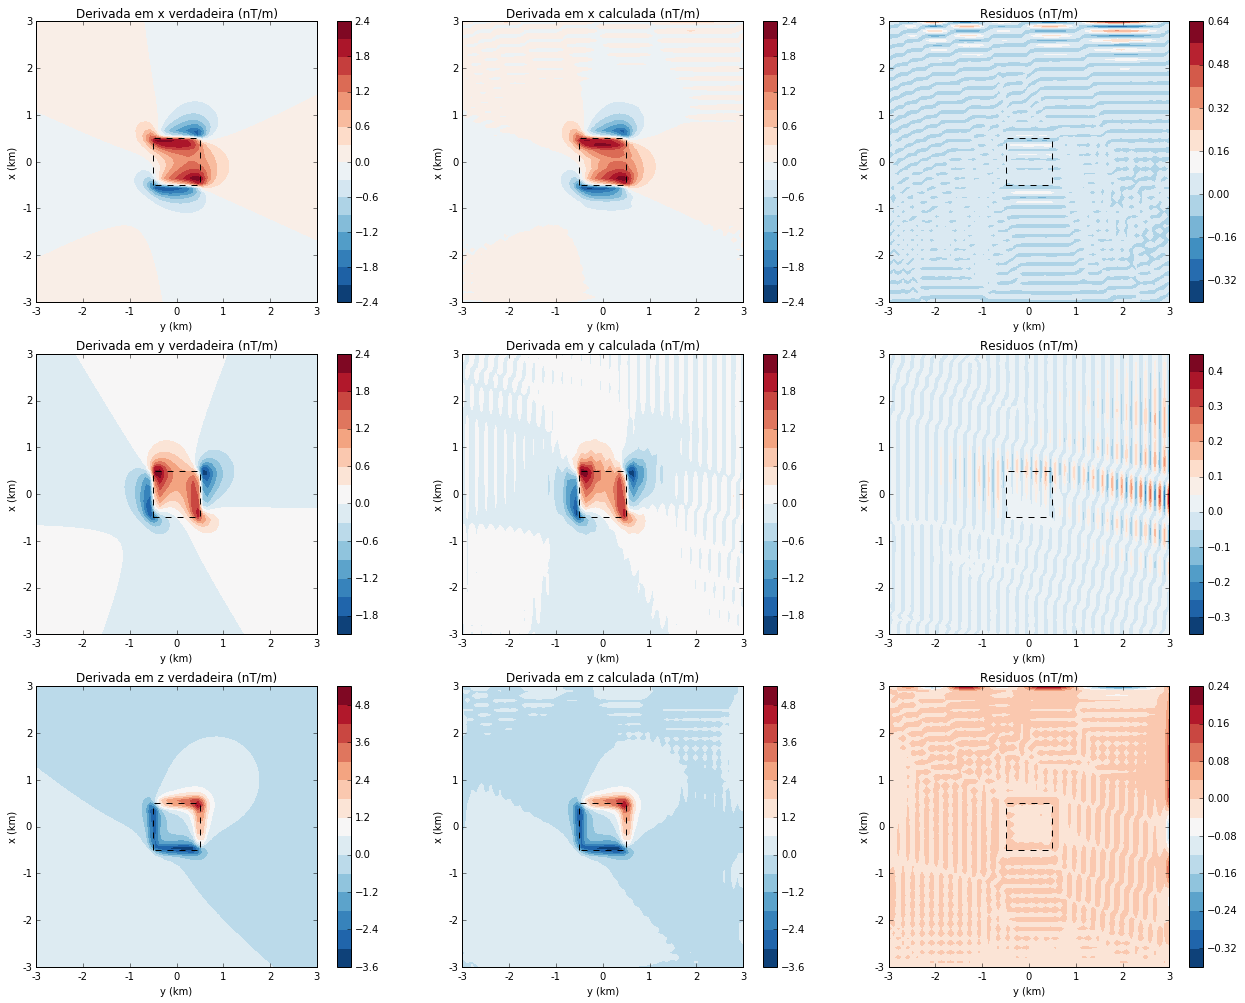

In [29]:
mpl.close('all')
mpl.figure(figsize=(18,14))

mpl.subplot(3,3,1)
mpl.title("Derivada em x verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,2)
mpl.title("Derivada em x calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,3)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_calculada - dx_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,4)
mpl.title("Derivada em y verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,5)
mpl.title("Derivada em y calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,6)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_calculada - dy_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,7)
mpl.title("Derivada em z verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,8)
mpl.title("Derivada em z calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,9)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_calculada - dz_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()